# 作业三：风格迁移——自由发挥

### 风格迁移：
图像风格迁移是指给出一个原始的内容图像，以及一种风格（可以是一张风格图像），将内容图像转变成为给出的风格，是一种用不同风格渲染图像语义内容的图像处理方法。

本实验参照了论文[Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593)，参照原论文、源代码，对**CycleGAN**模型进行了复现（所有代码均非照搬），并采用[monet2photo](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/)数据集，实现了将莫奈的画风迁移至真实照片、将莫奈画作还原为真实照片的目的。该模型的优点在于它的训练具有较强的通用性，它不需要配对的数据，只需要两组不同风格的照片即可完成训练。

模型基于GAN的思想，通过生成器不断提高伪造真实数据的能力、鉴别器不断提高鉴别伪造数据的能力的对抗训练，在对抗博弈的过程中提升整体效果。本质而言，该模型采用了两个对称的GAN，构成了一个环形网络。两个GAN共享两个生成器（$G$：$X$风格$\rightarrow Y$风格，$F$：$Y$风格$\rightarrow X$风格），并且各自享有一个判别器（$D_X$：判别是否为$X$风格，$D_Y$：判别是否为$Y$风格），共含有两个生成器、两个鉴别器，其结构如下图$(a)$所示：

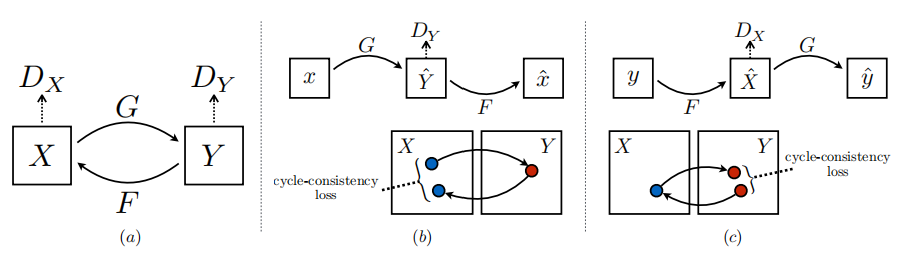


对于优化模型的损失函数，除了GAN特有的使得真实图片的得分尽可能高、生成器生成的图片的得分尽可能低的约束，本模型还引入了cycle consistency loss，见上图$(b)、(c)$，其思想在于给迁移的过程加入内容约束，使得生成器$G$生成的图片经过生成器$F$与输入图片一致，在实现风格迁移的同时保证内容细节不丢失。同时，引入了identity loss，以保持整体画风的一致。损失函数的选取在此不再赘述，将在`4.3`节结合代码详细展开。

模型得到莫奈画风的部分迁移结果如下：
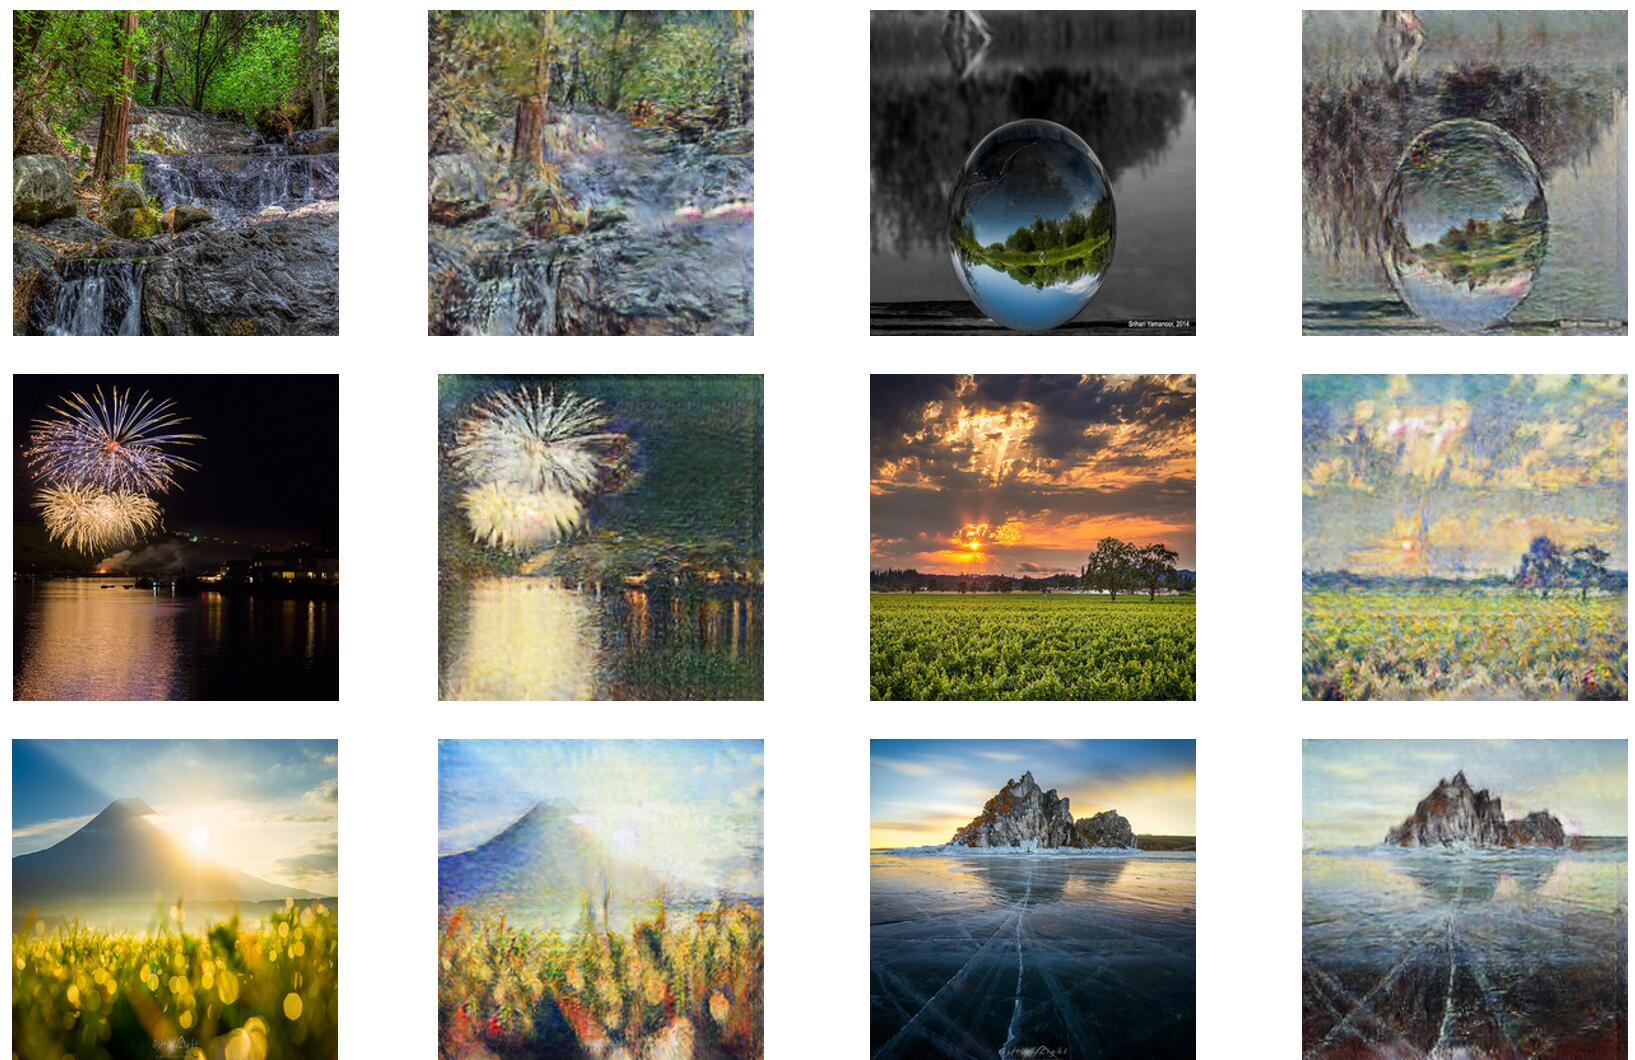

# 0. 安装、导入相关包

In [ ]:
! pip install wget
! pip install --upgrade jupyter

In [3]:
import glob
import random
import os
import torch
import itertools
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch import nn
from PIL import Image
import torch
import numpy as np
import wget
import zipfile
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. CycleGan网络模型
包括```Generator```和```Discriminator```两部分。`Generator`负责生成尽可能接近真实情况的图片，尺寸与输入图片相同；`Discriminator`负责尽可能分辨出伪造的图片，并输出相应得分。

### 1.0 Residual模块
`Generator`由ResNet中的`Residual`模块构成。该残差块包括2个卷积层，在每个卷积层后进行正则化，并在第一个正则化层后加入ReLU激活函数。该模块在转换图像风格时不影响图片的大小，因此可以叠加使用。

In [4]:
# Generator：ResNet 
# 残差块
class Residual(nn.Module):
    def __init__(self, in_features):
        super(Residual, self).__init__()
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),  # 上下左右填充一行(以最外围像素为对称轴，做四周的轴对称镜像填充)
            nn.Conv2d(in_features, in_features, 3),  # 3x3卷积
            nn.InstanceNorm2d(in_features),  # 归一层
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x+self.conv_block(x)


可以发现，经过Residual模块，图像的尺寸保持不变。

In [5]:
blk = Residual(3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

### 1.1 生成器 Generator
生成器的结构类似ResNet，由如下模块构成：


-    3个卷积块，用于**降采样**。每个模块包括一个2D卷积层、一个正则化层和ReLU激活函数。
-   9个残差块，见1.0节。
-   3个反卷积块，用于**上采样**。每个模块包括一个2D卷积层、一个正则化层和ReLU激活函数。
-   输出模块，包括一个2D卷积层和tanh激活函数。



In [6]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, num_residual_blocks=9):
        super(Generator, self).__init__()
        # 初始卷积模块
        n1 = [nn.ReflectionPad2d(3),
              nn.Conv2d(in_channels, 64, 7),
              nn.InstanceNorm2d(64),
              nn.ReLU(inplace=True)
              ]
        # 下采样卷积块
        in_features = 64
        out_features = in_features * 2
        n2 = []
        for _ in range(2):
            n2 += [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                   nn.InstanceNorm2d(out_features),
                   nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features*2
        # 残差块
        n3 = []
        for _ in range(num_residual_blocks):
            n3 += [Residual(in_features)]
        # 上采样块
        out_features = in_features // 2
        n4 = []
        for _ in range(2):
            n4 += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                   nn.InstanceNorm2d(out_features),
                   nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features // 2
        # 输出模块
        n5 = [nn.ReflectionPad2d(3),
              nn.Conv2d(64, out_channels, 7),
              nn.Tanh()]
        self.net = nn.Sequential(*n1,*n2,*n3,*n4,*n5)

    def forward(self, x):
        return self.net(x)

输入图片输入Generator后，生成图片大小保持不变，经过各层后的详细变化如下所示：

In [7]:
generator = Generator(3, 3)
X = torch.rand(size=(1, 3, 256, 256))
print('Initial shape:\t', X.shape)
for layer in generator.net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Initial shape:	 torch.Size([1, 3, 256, 256])
ReflectionPad2d output shape:	 torch.Size([1, 3, 262, 262])
Conv2d output shape:	 torch.Size([1, 64, 256, 256])
InstanceNorm2d output shape:	 torch.Size([1, 64, 256, 256])
ReLU output shape:	 torch.Size([1, 64, 256, 256])
Conv2d output shape:	 torch.Size([1, 128, 128, 128])
InstanceNorm2d output shape:	 torch.Size([1, 128, 128, 128])
ReLU output shape:	 torch.Size([1, 128, 128, 128])
Conv2d output shape:	 torch.Size([1, 256, 64, 64])
InstanceNorm2d output shape:	 torch.Size([1, 256, 64, 64])
ReLU output shape:	 torch.Size([1, 256, 64, 64])
Residual output shape:	 torch.Size([1, 256, 64, 64])
Residual output shape:	 torch.Size([1, 256, 64, 64])
Residual output shape:	 torch.Size([1, 256, 64, 64])
Residual output shape:	 torch.Size([1, 256, 64, 64])
Residual output shape:	 torch.Size([1, 256, 64, 64])
Residual output shape:	 torch.Size([1, 256, 64, 64])
Residual output shape:	 torch.Size([1, 256, 64, 64])
Residual output shape:	 torch.Size([1,

### 1.2 鉴别器 Discriminator
鉴别器的结构类似PatchGAN中的判别器，通过卷积网络提取特征并输出预测结果，由以下模块构成：


*   4个卷积块，由2D卷积层、正则化层、LeakReLU激活函数构成，第一个没有卷积块没有正则化层。
*   1个FCN全卷积网络层，得到一个1个通道的得分矩阵。
*   全局平均池化层，展平并输出，得到得分结果。



In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # 一系列卷积层
            nn.Conv2d(in_channels,64,4,stride=2,padding=1),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(256,512,4,padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(512,1,4,padding=1), # FCN全卷积网络层
            nn.AvgPool2d(30), # 全局平均池化
            nn.Flatten() # 展平
        )
    
    def forward(self, x):
        x = self.net(x)
        # print(x.shape)
        return x

In [9]:
discriminator = Discriminator(3)
print('Initial shape:\t', X.shape)
for layer in discriminator.net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Initial shape:	 torch.Size([1, 3, 256, 256])
Conv2d output shape:	 torch.Size([1, 64, 128, 128])
LeakyReLU output shape:	 torch.Size([1, 64, 128, 128])
Conv2d output shape:	 torch.Size([1, 128, 64, 64])
InstanceNorm2d output shape:	 torch.Size([1, 128, 64, 64])
LeakyReLU output shape:	 torch.Size([1, 128, 64, 64])
Conv2d output shape:	 torch.Size([1, 256, 32, 32])
InstanceNorm2d output shape:	 torch.Size([1, 256, 32, 32])
LeakyReLU output shape:	 torch.Size([1, 256, 32, 32])
Conv2d output shape:	 torch.Size([1, 512, 31, 31])
InstanceNorm2d output shape:	 torch.Size([1, 512, 31, 31])
LeakyReLU output shape:	 torch.Size([1, 512, 31, 31])
Conv2d output shape:	 torch.Size([1, 1, 30, 30])
AvgPool2d output shape:	 torch.Size([1, 1, 1, 1])
Flatten output shape:	 torch.Size([1, 1])


# 2. 工具箱：Utils
用于模型的训练，包含以下几种功能的实现函数：
* `Logger`：将训练过程损失函数的变化可视化。
* `ReplayBuffer`：存储gnerator生成的maximum_size张图像，并且随机返回一张。
* `LambdaLR`：学习率变化策略。
* `weights_init_normal`：网络层初始化。

In [10]:
# 结果、损失函数可视化
class Logger():
    def __init__(self, num_epochs, batches_per_epoch):
        self.num_epochs = num_epochs # epoch总数
        self.batches_per_epoch = batches_per_epoch # 一个epoch的batch总数
        self.current_epoch = 1 
        self.current_batch = 1
        self.losses_G = []
        self.losses_D = []
        self.losses_id = []
        self.losses_gg=[]
        self.losses_gc=[]
        
    def log(self):
        if (self.current_batch % self.batches_per_epoch) == 0:
            self.current_epoch += 1
            self.current_batch = 1 # 将batch重置为1
        else:
            self.current_batch += 1
        
    # 存储损失函数的值
    def save(self, losses = None):
        for i, loss_name in enumerate(losses.keys()):
            if loss_name == 'loss_G':
                self.losses_G.append(losses[loss_name])
            elif loss_name == 'loss_D':
                self.losses_D.append(losses[loss_name])
            elif loss_name == 'loss_G_GAN':
                self.losses_gg.append(losses[loss_name])
            elif loss_name == 'loss_G_cycle':
                self.losses_gc.append(losses[loss_name])
            else:
                self.losses_id.append(losses[loss_name])
            
    # 显示损失值变化曲线
    def visualize(self):
        loss_filename = 'loss.jpg'
        loss_path = './Figures/' + loss_filename

        x = np.array(range(1, self.current_epoch + 1))
        y1 = np.array(self.losses_G)
        y2 = np.array(self.losses_D)
        y3 = np.array(self.losses_id)
        y4 = np.array(self.losses_gg)
        y5 = np.array(self.losses_gc)

        plt.figure()
        plt.xlabel('Epoch', fontdict={'family': 'Times New Roman', 'size': 14})
        plt.ylabel('Loss', fontdict={'family': 'Times New Roman', 'size': 14})
        plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
        plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
        plt.plot(x, y3, 'darkviolet',color=(0.25,0.41,0.88), linewidth=1.0, label='Loss_G_identity')
        plt.plot(x, y4, 'darkviolet',color=(0.25,0.87,0.82), linewidth=1.0, label='Loss_G_GAN')
        plt.plot(x, y5, 'darkviolet', linewidth=1.0, label='Loss_G_cycle')
        plt.xticks(fontproperties='Times New Roman', size=10)
        plt.yticks(fontproperties='Times New Roman', size=10)
        plt.legend(prop={'family': 'Times New Roman', 'size': 10})
        plt.savefig(loss_path)
        plt.show()
# 存储gnerator生成的maximum_size张图像，并且随机返回一张
class ReplayBuffer():
    def __init__(self, maximum_size = 50):
        self.maximum_size = maximum_size
        self.data = []
    def push_and_pop(self,data):
        return_pic = []
        for pic in data.data:
            pic = torch.unsqueeze(pic,0)
            # 如果没有超过容量，则直接插入，并返回当前图片
            if len(self.data) < self.maximum_size:
                self.data.append(pic)
                return_pic.append(pic)
            else:
            # 如果超过容量，则以一定概率接受当前图像
                if random.uniform(0,1) > 1/2:
                    index = random.randint(0,self.maximum_size-1)
                    return_pic.append(self.data[index].clone()) # 如果接受当前图片，则返回替换掉的图片
                    self.data[index] = pic
                else:
                    return_pic.append(pic) # 如果不接受，返回当前图片
        return Variable(torch.cat(return_pic))
# 学习率变化策略
class LambdaLR():
    def __init__(self,num_epochs,offset,decay_start_epoch):
        self.num_epochs = num_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
    
    def step(self,epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.num_epochs - self.decay_start_epoch)

# 初始化网络层
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)

# 3. 模型配置：Config
包括各项必须的超参数、数据集存储路径及设备信息。

In [11]:
# 超参数设置
in_channels = 3 # 输入通道
out_channels = 3 # 输出通道
lr = 2e-3 # 学习率
size_data = 256 # 图像的大小为256x256
num_epochs = 120 # 迭代的epoch
decay_start_epoch = 50 # 开始权重衰减的epoch
current_epoch = 0 # 当前的epoch
batch_size = 1 # 一个mini-batch的大小
# Adam参数
b1 = 0.5  
b2 = 0.999
# 数据集存储路径
root = './datasets/monet2photo/'
# 设备信息
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# 3. 数据处理

### 3.1 数据下载 & 文件夹结构搭建
采用数据集[monet2photo](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/)，训练集和测试集共包括经过数据增强后的1193张莫奈画作和7038张自然照片。经过训练后，可以实现照片→莫奈画作和莫奈画作→照片的转换。

文件夹结构如下，为采用下述下载方式后的本地文件夹结构。

```
project   
│
└───datasets（存放数据集）
│   │
│   └───monet2photo 
│       │   trainA 
│       │   trainB  
│       │   testA
│       │   testB
│
└───saved_models（存放模型参数）
│   
└───Figures（存放loss变化的数据）
│   
└───output（模型预测结果）
│   │   A（生成的莫奈风格的图片） 
│   │   B（莫奈画作转化为照片的结果）  

    
```

In [12]:
def setup():
    # 搭建文件夹结构
    folders = ['./datasets','./saved_models','./Figures','./output/A','./output/B']
    for folder in folders:
        if not os.path.exists(folder):
            os.mkdir(folder)
    # 下载并解压数据
    if not os.path.exists('./datasets/monet2photo'):
        print("monet2photo not exists")
        if not os.path.exists('./datasets/monet2photo.zip'):
            print("downloading~")
            wget.download('https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/monet2photo.zip', '/data/meta/datasets/monet2photo.zip')
        with zipfile.ZipFile('./datasets/monet2photo.zip') as zf:
            zf.extractall('./datasets')
        print("finish")
        os.remove('./datasets/monet2photo.zip')
    else:
        print("monet2photo exists")
        
setup()

monet2photo exists


### 3.2 数据集类：ImageDataset
继承Dataset类，将数据集分成A（莫奈画作）和B（照片）两类，用于模型的训练和测试，各函数功能如下：
- `__init__`：读入数据集中A和B的路径。
- `__getitem__`：读取两个文件夹中的数据。
- `__len__`：返回两个文件夹中数据数量的最大值。


In [13]:
class ImageDataset(Dataset):
    def __init__(self, root, Transform=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(Transform)
        self.unaligned = unaligned
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*')) 
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))
        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

# 4. 模型的训练

### 4.1 训练数据载入和预处理
对训练数据进行随机裁剪、水平翻转、正则化等操作，初始化dataloader。

In [14]:
# 图片预处理
Transform = [# 调整image的尺寸 
    transforms.Resize(
        int(size_data * 1.12), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomCrop(size_data),  # 随机裁剪
    transforms.RandomHorizontalFlip(),  # 水平翻转
    transforms.ToTensor(),  # 转为tensor
    # 归一化
    transforms.Normalize(0.5, 0.5)]

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# 输入数据
input_A = Tensor(batch_size, in_channels, size_data, size_data)
input_B = Tensor(batch_size, out_channels, size_data, size_data)

# 初始化，存储生成器所生成的数据，用于鉴别器的训练
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# 鉴别器的目标分数：1为真，0为假
target_real = Variable(Tensor(np.ones((batch_size,1))), requires_grad=False)
target_fake = Variable(Tensor(np.zeros((batch_size,1))), requires_grad=False)

# 加载数据
dataloader = DataLoader(ImageDataset(root, Transform, unaligned=True), batch_size, shuffle=True)

### 4.2 模型的初始化
该部分对生成器、鉴别器、损失函数和优化器等模型必要的结构进行了初始化，具体操作如下：


*   生成器、鉴别器的初始化。
*   模型参数的初始化或已有参数的导入。
*   损失函数的初始化。
*   优化器的初始化，采用Adam优化器。
*   学习率衰减的设置，其中`lr_lambda`参数由utils中的`Lambda`类控制。
*   可视化设置：损失函数绘制及进度条绘制。



In [15]:
# 生成器、鉴别器初始化
Generator_A2B = Generator(in_channels, out_channels).to(device)
Generator_B2A = Generator(out_channels, in_channels).to(device)
Discriminator_A = Discriminator(in_channels).to(device)
Discriminator_B = Discriminator(out_channels).to(device)

# 参数初始化/导入
if current_epoch != 0:
    Generator_A2B.load_state_dict(torch.load("saved_models/Generator_A2B.pth"))
    Generator_B2A.load_state_dict(torch.load("saved_models/Generator_B2A.pth"))
    Discriminator_A.load_state_dict(torch.load("saved_models/Discriminator_A.pth"))
    Discriminator_B.load_state_dict(torch.load("saved_models/Discriminator_B.pth"))
else:
    weights_init_normal(Generator_A2B)
    weights_init_normal(Generator_B2A)
    weights_init_normal(Discriminator_A)
    weights_init_normal(Discriminator_B)

# 损失函数初始化
criterion_GAN = torch.nn.MSELoss().to(device)
criterion_cycle = torch.nn.L1Loss().to(device)
criterion_identity = torch.nn.L1Loss().to(device)

# 优化器设置
optimizer_Generator = torch.optim.Adam(itertools.chain(
    Generator_A2B.parameters(), Generator_B2A.parameters()), lr, betas=(
                                                                b1, b2))
optimizer_Discriminator_A = torch.optim.Adam(
    Discriminator_A.parameters(), lr, betas=(b1, b2))
optimizer_Discriminator_B = torch.optim.Adam(
    Discriminator_B.parameters(), lr, betas=(b1, b2))

# 学习率衰减（设置学习率为初始学习率乘以给定lr_lambda函数的值）
lr_scheduler_Generator = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Generator, lr_lambda=LambdaLR(
        num_epochs, current_epoch, decay_start_epoch).step)

lr_scheduler_Discriminator_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Discriminator_A, lr_lambda=LambdaLR(
        num_epochs, current_epoch, decay_start_epoch).step)

lr_scheduler_Discriminator_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Discriminator_B, lr_lambda=LambdaLR(
        num_epochs, current_epoch, decay_start_epoch).step)

# 损失函数绘制
logger = Logger(num_epochs, int(len(dataloader) / batch_size) + 1)
# 进度条呈现
total_train_steps = (int(len(dataloader) / batch_size) + 1) * num_epochs
pbar = tqdm(total=total_train_steps)


  0%|                                                                                        | 0/77880 [00:00<?, ?it/s]

### 4.3 训练主体和训练过程的显示
训练过程包括两个部分：


1.   固定鉴别器，训练生成器，该部分的损失函数由以下三部分构成：

    * **GAN Loss**：使得生成器在鉴别器中的得分越高越好，即使得生成图像更加真实。
    * **Cycle Consistency Loss**：对于输入x，经过生成y的生成器生成了fake y，再将生成图片放入生成x的生成器，结果应该与输入的$x$相差无几，这样构成了一个循环，减少生成过程中的内容丢失： $$L_{\text {cycle }}(G, F)=\mathbb{E}_{x \sim p_{\text {data }}(x)}\left[\|F(G(x))-x\|_{1}\right]+\mathbb{E}_{y \sim p_{\text {data }}(y)}\left[\|G(F(y))-y\|_{1}\right]$$ 
    
    * **Identity loss**：生成器生成了y风格的图像，将该图像仍送入原生成器，得到结果应与y尽可能接近。否则，生成器整体色调可能发生变化$$L_{\text {Identity }}(G, F)=\mathbb{E}_{y \sim p_{\text {data }}(y)}\left[\|G(y)-y\|_{1}\right]+\mathbb{E}_{x \sim p_{\text {data }}(x)}\left[\|F(x)-x\|_{1}\right]$$ 

2.   固定生成器，分别训练鉴别器A、B，该部分的loss为GAN所通用的**Adversarial Loss**，使得真实图片的得分尽可能高，生成器生成的图片的得分尽可能低：$$\begin{aligned} L_{\mathrm{GAN}}\left(G, D_{Y}, X, Y\right) =\mathbb{E}_{y \sim p_{\text {data }}(y)}\left[\log D_{Y}(y)\right] +\mathbb{E}_{x \sim p_{\text {data }}(x)}\left[\log \left(1-D_{Y}(G(x))\right]\right.\end{aligned}$$

通过上述对抗训练，实现了模型的训练与优化。



[EPOCH 0/120] [loss_G:2.431464,loss_D:0.615495]:   1%|          | 648/77880 [01:48<3:09:30,  6.79it/s]    /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will ta

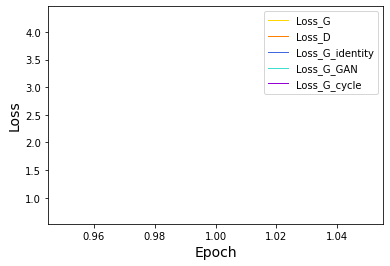

[EPOCH 1/120] [loss_G:2.072393,loss_D:0.519315]:   2%|▏         | 1296/77880 [03:28<3:13:54,  6.58it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will tak

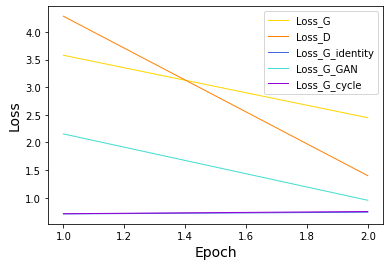

[EPOCH 2/120] [loss_G:2.217696,loss_D:0.059868]:   2%|▏         | 1944/77880 [05:14<3:05:12,  6.83it/s]    /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

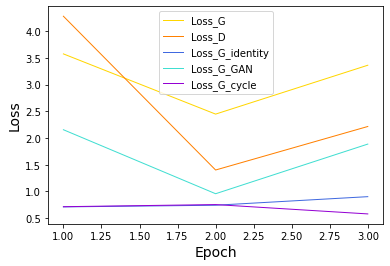

[EPOCH 3/120] [loss_G:2.865423,loss_D:0.073278]:   3%|▎         | 2592/77880 [06:53<3:01:00,  6.93it/s]    /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

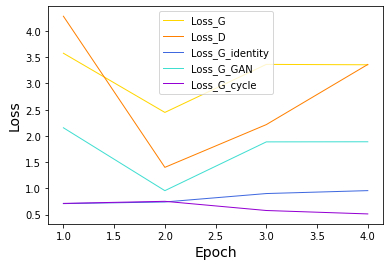

[EPOCH 4/120] [loss_G:2.262533,loss_D:0.099972]:   4%|▍         | 3240/77880 [08:32<3:01:57,  6.84it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take 

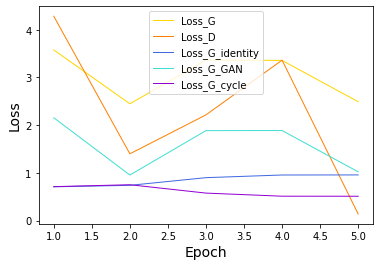

[EPOCH 5/120] [loss_G:2.151052,loss_D:0.108324]:   5%|▍         | 3888/77880 [10:14<4:31:35,  4.54it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take

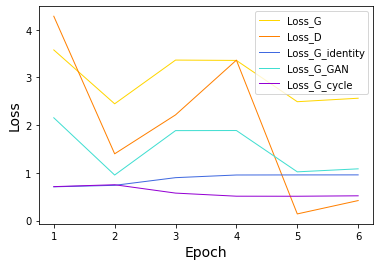

[EPOCH 6/120] [loss_G:2.604491,loss_D:0.100580]:   6%|▌         | 4536/77880 [11:53<2:53:42,  7.04it/s]   /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will ta

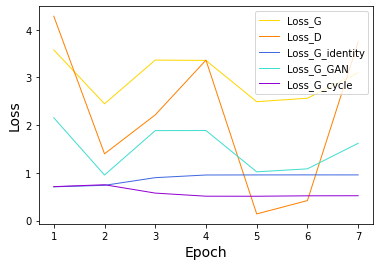

[EPOCH 7/120] [loss_G:2.744972,loss_D:0.136186]:   7%|▋         | 5184/77880 [13:32<2:58:27,  6.79it/s]   /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will ta

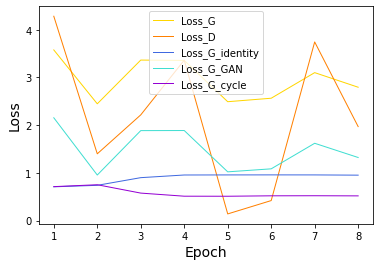

[EPOCH 8/120] [loss_G:2.817764,loss_D:0.042762]:   7%|▋         | 5832/77880 [15:11<2:56:28,  6.80it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take

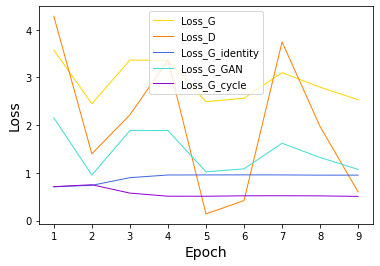

[EPOCH 9/120] [loss_G:2.350224,loss_D:0.035163]:   8%|▊         | 6480/77880 [16:48<2:55:20,  6.79it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will tak

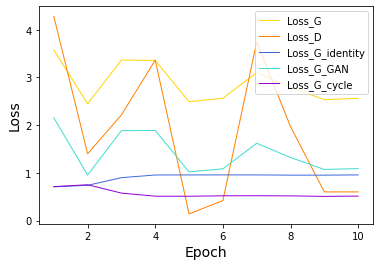

[EPOCH 10/120] [loss_G:2.168899,loss_D:0.037510]:   9%|▉         | 7128/77880 [18:27<2:53:26,  6.80it/s]     /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

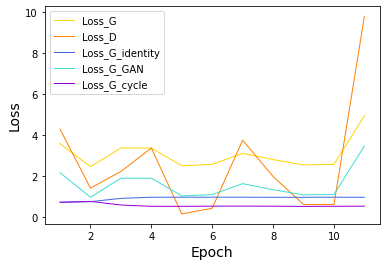

[EPOCH 11/120] [loss_G:2.216470,loss_D:0.538192]:  10%|▉         | 7776/77880 [20:05<3:16:42,  5.94it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take

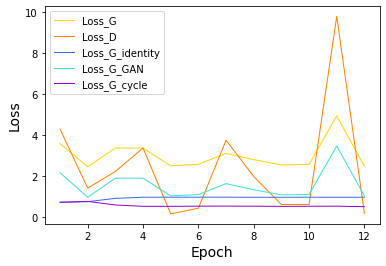

[EPOCH 12/120] [loss_G:2.260785,loss_D:0.060046]:  11%|█         | 8424/77880 [21:43<2:49:14,  6.84it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take

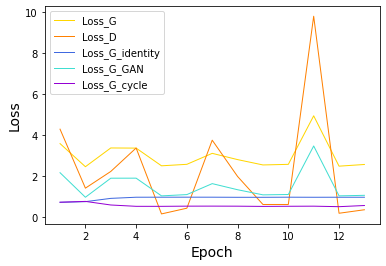

[EPOCH 13/120] [loss_G:2.618895,loss_D:0.265071]:  12%|█▏        | 9072/77880 [23:22<2:46:37,  6.88it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will tak

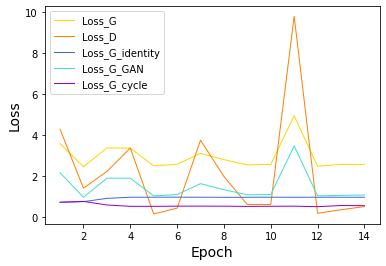

[EPOCH 14/120] [loss_G:2.964595,loss_D:0.158097]:  12%|█▏        | 9720/77880 [25:00<2:47:32,  6.78it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take

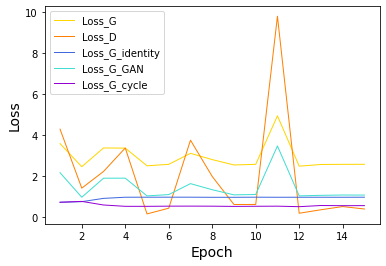

[EPOCH 15/120] [loss_G:1.930025,loss_D:0.350897]:  13%|█▎        | 10368/77880 [26:37<2:44:50,  6.83it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

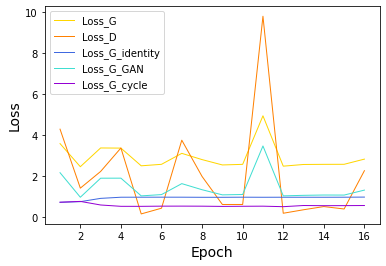

[EPOCH 16/120] [loss_G:2.574818,loss_D:0.133773]:  14%|█▍        | 11016/77880 [28:15<3:07:22,  5.95it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will ta

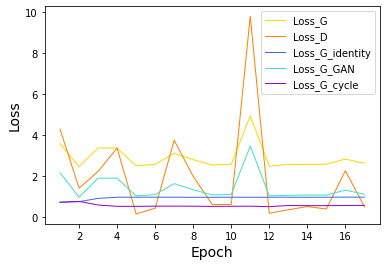

[EPOCH 17/120] [loss_G:2.555493,loss_D:0.193507]:  15%|█▍        | 11664/77880 [29:53<2:50:59,  6.45it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will tak

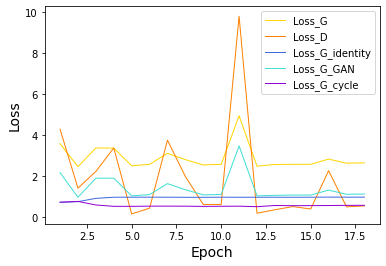

[EPOCH 18/120] [loss_G:2.595893,loss_D:0.330662]:  16%|█▌        | 12312/77880 [31:30<2:38:48,  6.88it/s]   /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will 

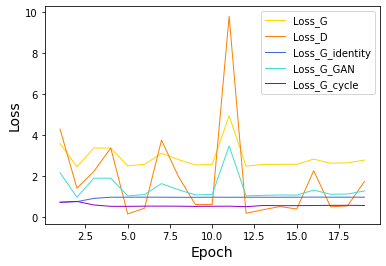

[EPOCH 19/120] [loss_G:2.140026,loss_D:0.085283]:  17%|█▋        | 12960/77880 [33:08<2:34:45,  6.99it/s]   /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will 

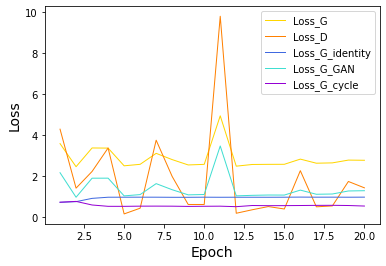

[EPOCH 20/120] [loss_G:2.496340,loss_D:0.074301]:  17%|█▋        | 13608/77880 [34:46<2:36:21,  6.85it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will ta

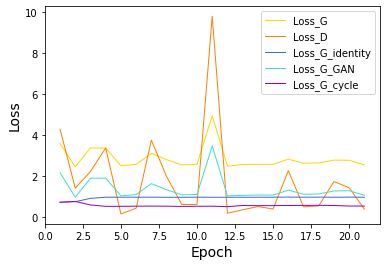

[EPOCH 21/120] [loss_G:3.250699,loss_D:1.077396]:  18%|█▊        | 14256/77880 [36:24<2:35:22,  6.82it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will ta

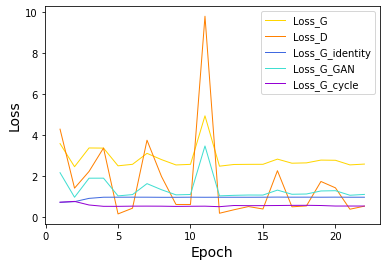

[EPOCH 22/120] [loss_G:3.123293,loss_D:0.171870]:  19%|█▉        | 14904/77880 [38:02<2:43:33,  6.42it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will tak

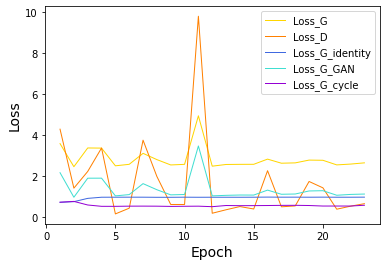

[EPOCH 23/120] [loss_G:2.356953,loss_D:0.037029]:  20%|█▉        | 15552/77880 [39:40<2:30:24,  6.91it/s]    /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

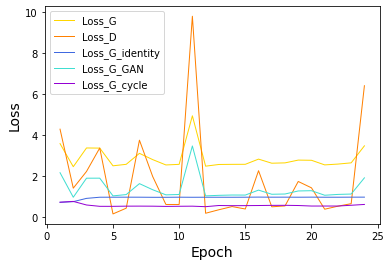

[EPOCH 24/120] [loss_G:2.550632,loss_D:0.203347]:  21%|██        | 16200/77880 [41:17<2:33:16,  6.71it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

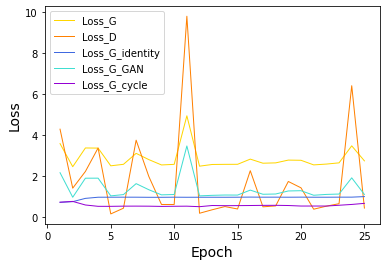

[EPOCH 25/120] [loss_G:2.703251,loss_D:0.165129]:  22%|██▏       | 16848/77880 [42:55<2:28:21,  6.86it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will tak

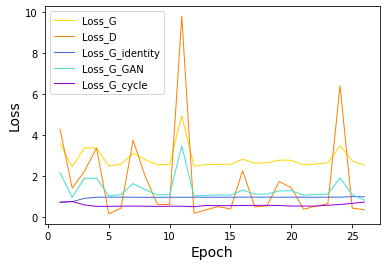

[EPOCH 26/120] [loss_G:3.291177,loss_D:0.519077]:  22%|██▏       | 17496/77880 [44:32<2:22:59,  7.04it/s]    /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

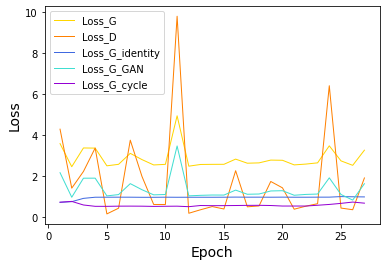

[EPOCH 27/120] [loss_G:3.158204,loss_D:0.765522]:  23%|██▎       | 18144/77880 [46:10<2:29:31,  6.66it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will tak

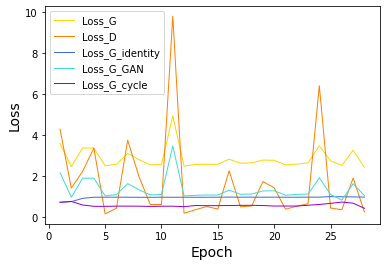

[EPOCH 28/120] [loss_G:2.016213,loss_D:0.056747]:  24%|██▍       | 18792/77880 [47:48<2:31:29,  6.50it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will ta

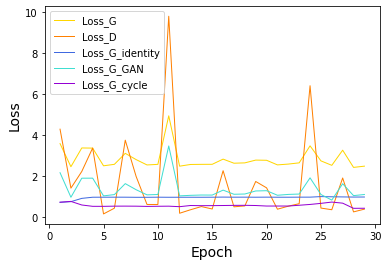

[EPOCH 29/120] [loss_G:4.762226,loss_D:4.506335]:  25%|██▍       | 19440/77880 [49:26<2:19:19,  6.99it/s]   /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will 

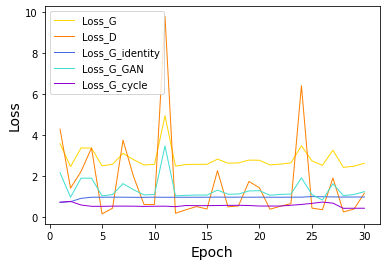

[EPOCH 30/120] [loss_G:2.437570,loss_D:0.035620]:  26%|██▌       | 20088/77880 [51:04<2:22:57,  6.74it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will ta

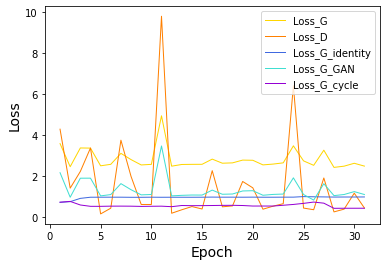

[EPOCH 31/120] [loss_G:2.381917,loss_D:0.031641]:  27%|██▋       | 20736/77880 [52:41<2:17:10,  6.94it/s]   /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will 

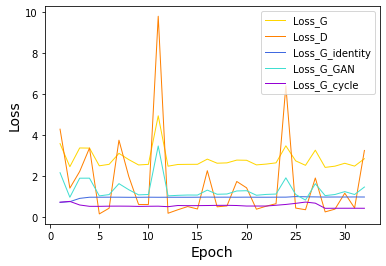

[EPOCH 32/120] [loss_G:2.549143,loss_D:0.057523]:  27%|██▋       | 21384/77880 [54:17<2:21:11,  6.67it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will ta

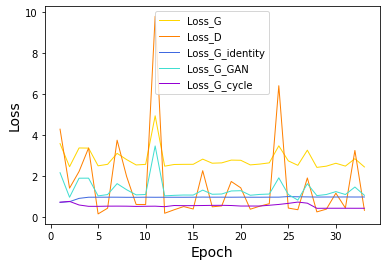

[EPOCH 33/120] [loss_G:2.383047,loss_D:0.098145]:  28%|██▊       | 22032/77880 [55:54<2:12:06,  7.05it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will tak

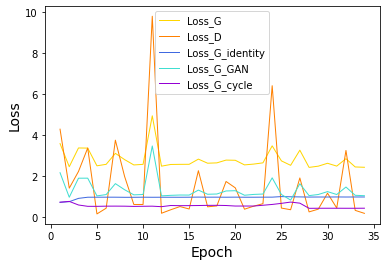

[EPOCH 34/120] [loss_G:2.420320,loss_D:0.300036]:  29%|██▉       | 22680/77880 [57:31<2:11:10,  7.01it/s]    /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

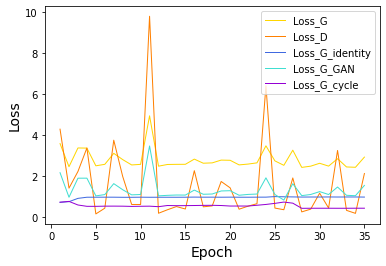

[EPOCH 35/120] [loss_G:2.295645,loss_D:0.018639]:  30%|██▉       | 23328/77880 [59:08<2:18:39,  6.56it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

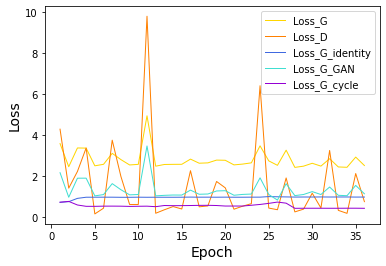

[EPOCH 36/120] [loss_G:2.607507,loss_D:0.027631]:  31%|███       | 23976/77880 [1:00:46<2:28:57,  6.03it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

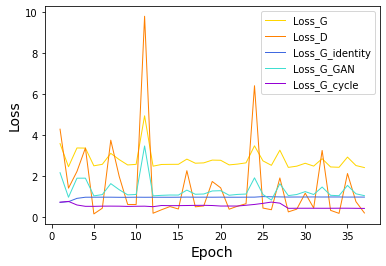

[EPOCH 37/120] [loss_G:2.363782,loss_D:0.245359]:  32%|███▏      | 24624/77880 [1:02:23<2:11:04,  6.77it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

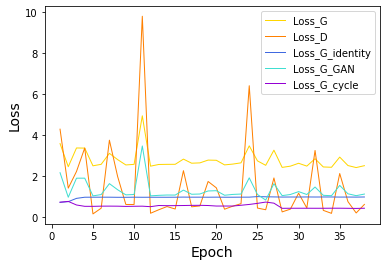

[EPOCH 38/120] [loss_G:2.601995,loss_D:0.047055]:  32%|███▏      | 25272/77880 [1:04:01<2:07:14,  6.89it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will 

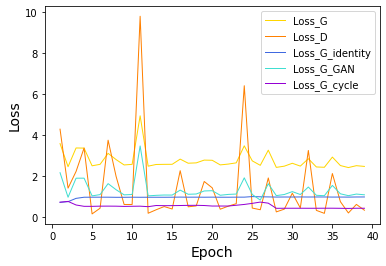

[EPOCH 39/120] [loss_G:2.563013,loss_D:0.166885]:  33%|███▎      | 25920/77880 [1:05:39<2:09:21,  6.69it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

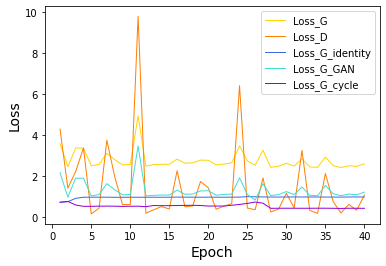

[EPOCH 40/120] [loss_G:2.416297,loss_D:0.055173]:  34%|███▍      | 26568/77880 [1:07:18<2:02:34,  6.98it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

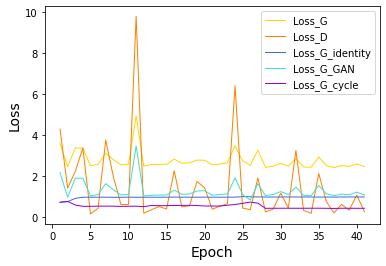

[EPOCH 41/120] [loss_G:2.246916,loss_D:0.036928]:  35%|███▍      | 27216/77880 [1:09:01<2:08:40,  6.56it/s]   /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument wil

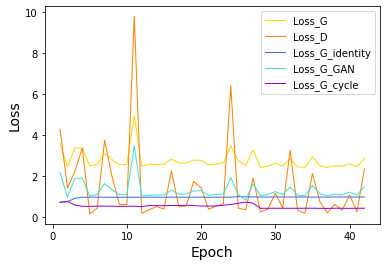

[EPOCH 42/120] [loss_G:1.894710,loss_D:0.850342]:  36%|███▌      | 27864/77880 [1:10:48<2:02:24,  6.81it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

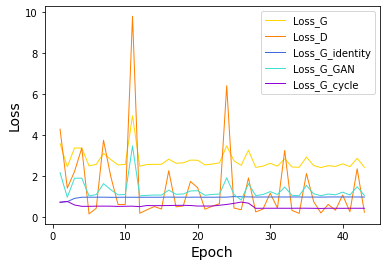

[EPOCH 43/120] [loss_G:3.053021,loss_D:0.917992]:  37%|███▋      | 28512/77880 [1:12:31<2:49:46,  4.85it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

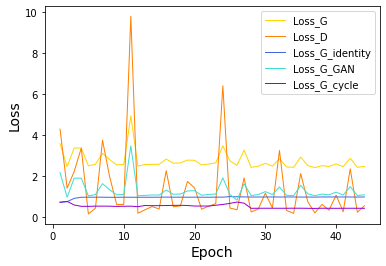

[EPOCH 44/120] [loss_G:2.845700,loss_D:0.595911]:  37%|███▋      | 29160/77880 [1:14:12<1:58:58,  6.82it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

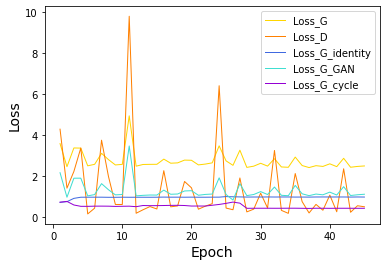

[EPOCH 45/120] [loss_G:2.241409,loss_D:0.044340]:  38%|███▊      | 29808/77880 [1:15:53<1:58:49,  6.74it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

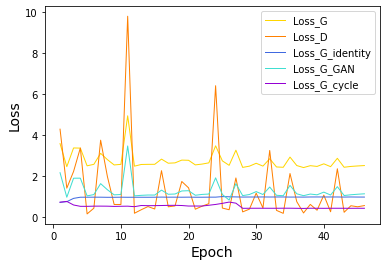

[EPOCH 46/120] [loss_G:5.374005,loss_D:5.513731]:  39%|███▉      | 30456/77880 [1:17:34<1:54:11,  6.92it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

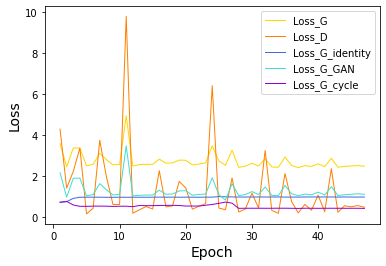

[EPOCH 47/120] [loss_G:2.404008,loss_D:0.035858]:  40%|███▉      | 31104/77880 [1:19:15<1:59:27,  6.53it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

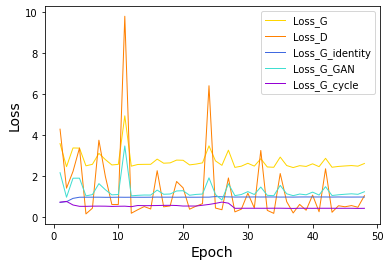

[EPOCH 48/120] [loss_G:3.082887,loss_D:0.392468]:  41%|████      | 31752/77880 [1:20:58<1:54:53,  6.69it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

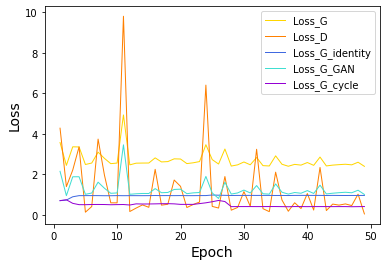

[EPOCH 49/120] [loss_G:2.335239,loss_D:0.042684]:  42%|████▏     | 32400/77880 [1:22:38<1:49:17,  6.94it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

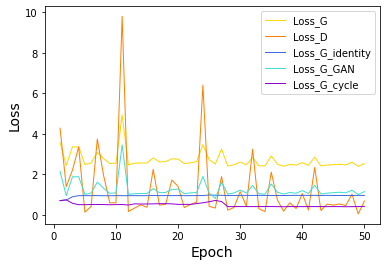

[EPOCH 50/120] [loss_G:2.243437,loss_D:0.029436]:  42%|████▏     | 33048/77880 [1:24:15<1:50:33,  6.76it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

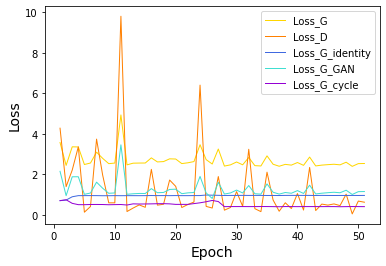

[EPOCH 51/120] [loss_G:2.123866,loss_D:0.114390]:  43%|████▎     | 33696/77880 [1:25:50<1:44:45,  7.03it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

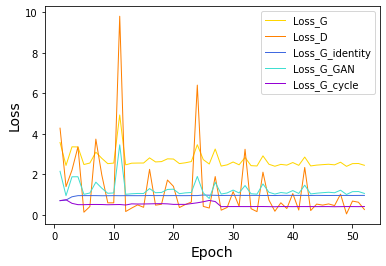

[EPOCH 52/120] [loss_G:2.095889,loss_D:0.224242]:  44%|████▍     | 34344/77880 [1:27:26<1:43:46,  6.99it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

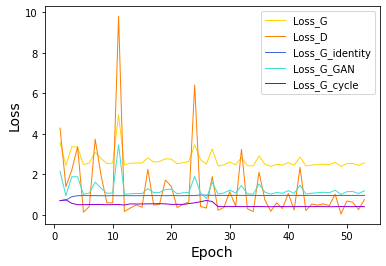

[EPOCH 53/120] [loss_G:2.439905,loss_D:0.098388]:  45%|████▍     | 34992/77880 [1:29:03<1:45:32,  6.77it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

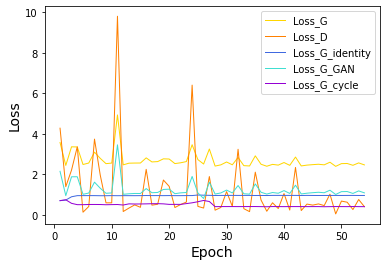

[EPOCH 54/120] [loss_G:2.563240,loss_D:0.350104]:  46%|████▌     | 35640/77880 [1:30:38<1:41:08,  6.96it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will 

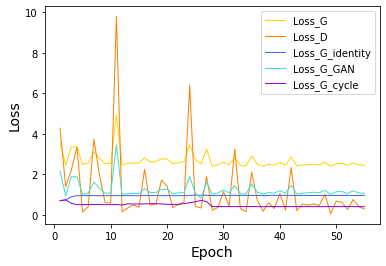

[EPOCH 55/120] [loss_G:2.266874,loss_D:0.014096]:  47%|████▋     | 36288/77880 [1:32:15<1:41:41,  6.82it/s]   /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument wil

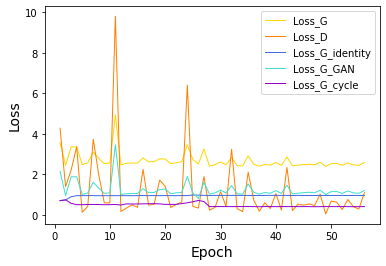

[EPOCH 56/120] [loss_G:2.474632,loss_D:0.016614]:  47%|████▋     | 36936/77880 [1:33:51<1:38:23,  6.94it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will 

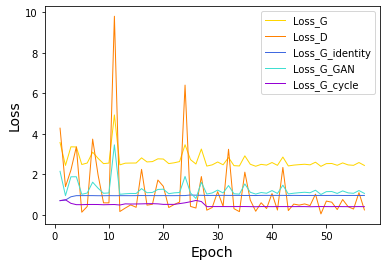

[EPOCH 57/120] [loss_G:2.351558,loss_D:0.033565]:  48%|████▊     | 37584/77880 [1:35:28<1:35:58,  7.00it/s]   /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument wil

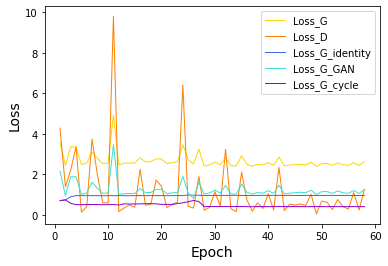

[EPOCH 58/120] [loss_G:2.200041,loss_D:0.029403]:  49%|████▉     | 38232/77880 [1:37:02<1:35:19,  6.93it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will 

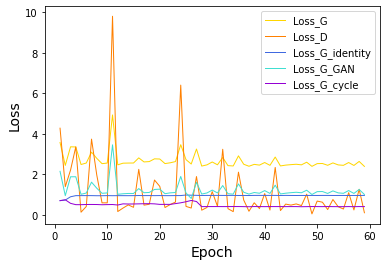

[EPOCH 59/120] [loss_G:2.246412,loss_D:0.021290]:  50%|████▉     | 38880/77880 [1:38:37<1:35:58,  6.77it/s]   /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument wil

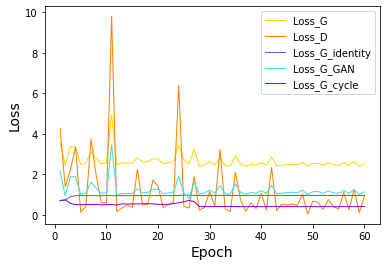

[EPOCH 60/120] [loss_G:2.440415,loss_D:0.005951]:  51%|█████     | 39528/77880 [1:40:11<1:30:23,  7.07it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will 

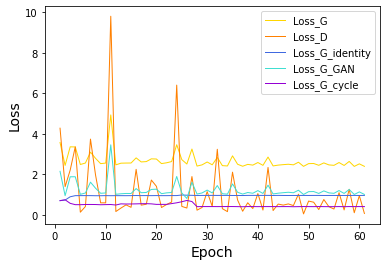

[EPOCH 61/120] [loss_G:4.626114,loss_D:4.497288]:  52%|█████▏    | 40176/77880 [1:41:45<1:30:20,  6.96it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will 

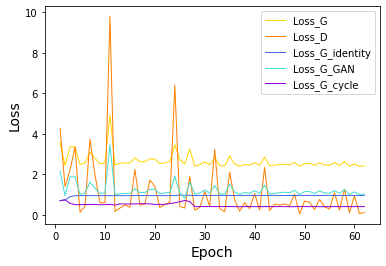

[EPOCH 62/120] [loss_G:2.174489,loss_D:0.181532]:  52%|█████▏    | 40824/77880 [1:43:20<1:29:07,  6.93it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will 

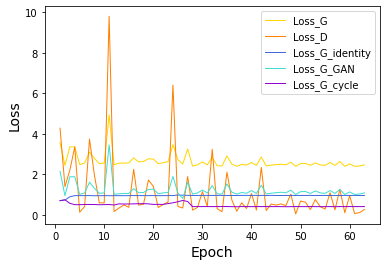

[EPOCH 63/120] [loss_G:2.329642,loss_D:0.016268]:  53%|█████▎    | 41472/77880 [1:44:55<1:28:03,  6.89it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will 

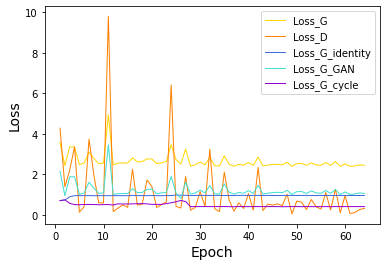

[EPOCH 64/120] [loss_G:2.466505,loss_D:0.005787]:  54%|█████▍    | 42120/77880 [1:46:30<1:27:11,  6.84it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

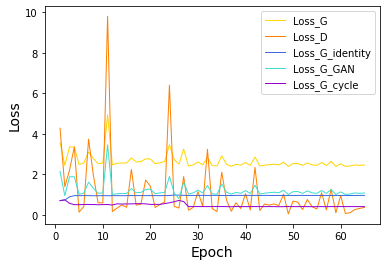

[EPOCH 65/120] [loss_G:2.477714,loss_D:0.033085]:  55%|█████▍    | 42768/77880 [1:48:04<1:24:05,  6.96it/s]   /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument wil

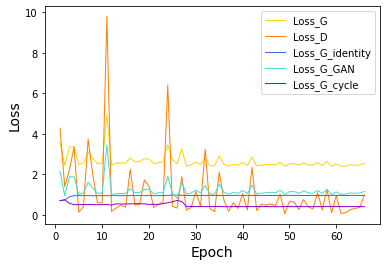

[EPOCH 66/120] [loss_G:2.354686,loss_D:0.042780]:  56%|█████▌    | 43416/77880 [1:49:38<1:24:50,  6.77it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will 

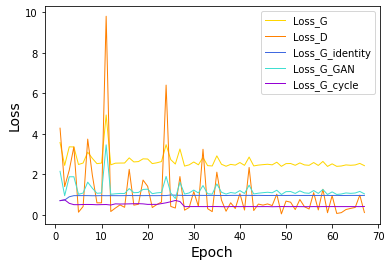

[EPOCH 67/120] [loss_G:2.216210,loss_D:0.022698]:  57%|█████▋    | 44064/77880 [1:51:12<1:20:09,  7.03it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

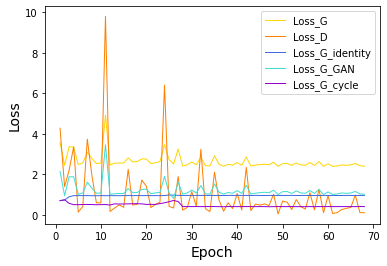

[EPOCH 68/120] [loss_G:2.221291,loss_D:0.005925]:  57%|█████▋    | 44712/77880 [1:52:47<1:19:36,  6.94it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

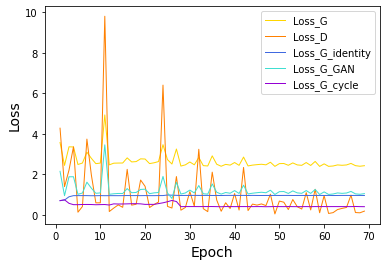

[EPOCH 69/120] [loss_G:2.473245,loss_D:0.042422]:  58%|█████▊    | 45360/77880 [1:54:22<1:17:56,  6.95it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

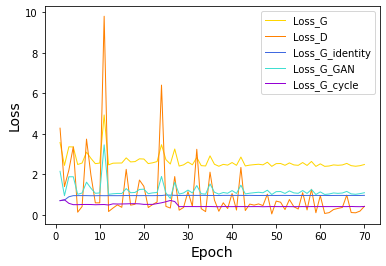

[EPOCH 70/120] [loss_G:2.657754,loss_D:0.017459]:  59%|█████▉    | 46008/77880 [1:55:58<1:17:30,  6.85it/s]   /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument wil

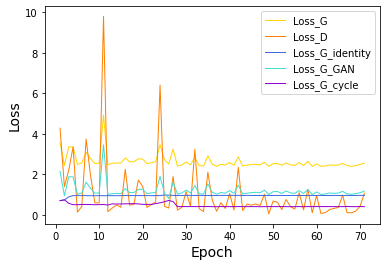

[EPOCH 71/120] [loss_G:2.414039,loss_D:0.012960]:  60%|█████▉    | 46656/77880 [1:57:36<1:19:35,  6.54it/s]   /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument wil

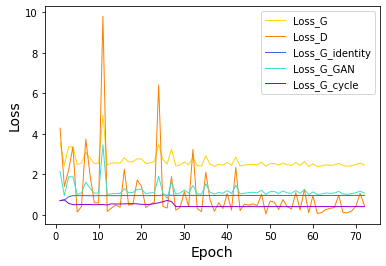

[EPOCH 72/120] [loss_G:2.442780,loss_D:0.003368]:  61%|██████    | 47304/77880 [1:59:12<1:12:36,  7.02it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

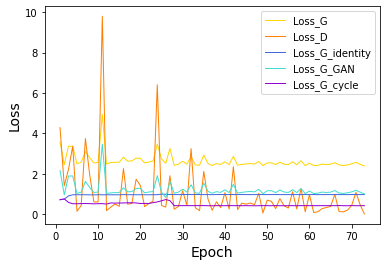

[EPOCH 73/120] [loss_G:2.747703,loss_D:0.025982]:  62%|██████▏   | 47952/77880 [2:00:51<1:44:23,  4.78it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

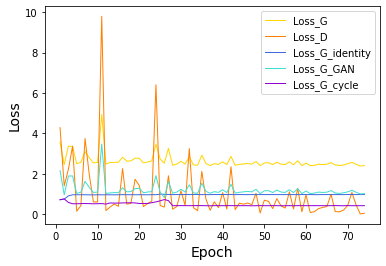

[EPOCH 74/120] [loss_G:3.602939,loss_D:1.227273]:  62%|██████▏   | 48600/77880 [2:02:34<1:45:44,  4.61it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

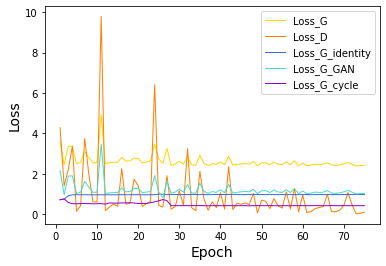

[EPOCH 75/120] [loss_G:2.367189,loss_D:0.002560]:  63%|██████▎   | 49248/77880 [2:04:18<1:11:15,  6.70it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

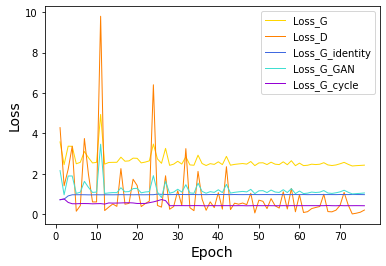

[EPOCH 76/120] [loss_G:2.293579,loss_D:0.003651]:  64%|██████▍   | 49896/77880 [2:06:03<1:15:02,  6.22it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

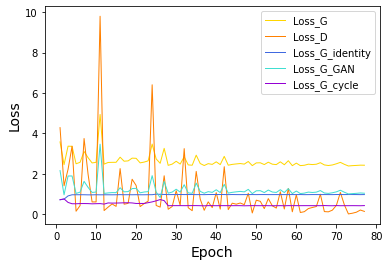

[EPOCH 77/120] [loss_G:2.323607,loss_D:0.009152]:  65%|██████▍   | 50544/77880 [2:07:49<1:15:29,  6.03it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

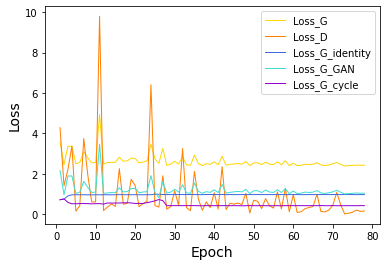

[EPOCH 78/120] [loss_G:2.218055,loss_D:0.011641]:  66%|██████▌   | 51192/77880 [2:09:32<1:04:51,  6.86it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

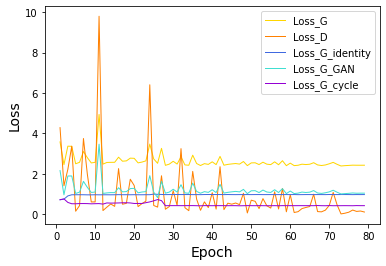

[EPOCH 79/120] [loss_G:2.605927,loss_D:0.005829]:  67%|██████▋   | 51840/77880 [2:11:07<1:03:18,  6.86it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will 

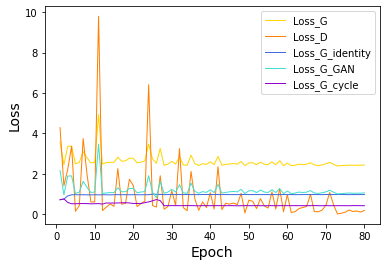

[EPOCH 80/120] [loss_G:2.433889,loss_D:0.004179]:  67%|██████▋   | 52488/77880 [2:12:43<1:01:33,  6.88it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

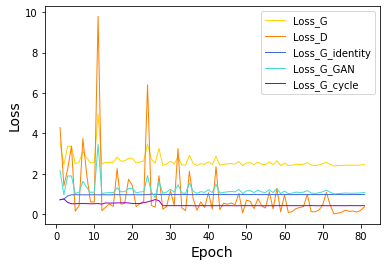

[EPOCH 81/120] [loss_G:2.572007,loss_D:0.001883]:  68%|██████▊   | 53136/77880 [2:14:19<1:01:06,  6.75it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will

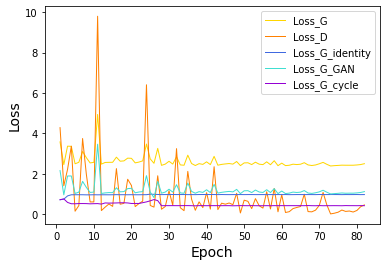

[EPOCH 82/120] [loss_G:2.362757,loss_D:0.003794]:  69%|██████▉   | 53784/77880 [2:15:56<58:28,  6.87it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

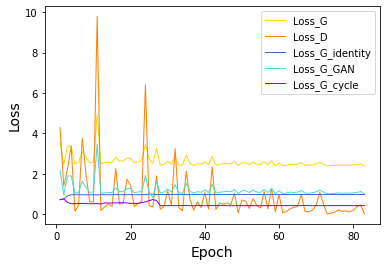

[EPOCH 83/120] [loss_G:2.254735,loss_D:0.341152]:  70%|██████▉   | 54432/77880 [2:17:32<57:04,  6.85it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

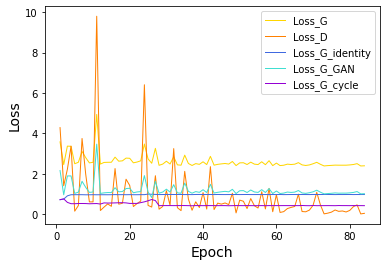

[EPOCH 84/120] [loss_G:2.236681,loss_D:0.009407]:  71%|███████   | 55080/77880 [2:19:08<56:16,  6.75it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

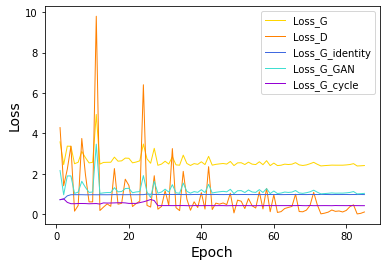

[EPOCH 85/120] [loss_G:2.471529,loss_D:0.009322]:  72%|███████▏  | 55728/77880 [2:20:46<58:39,  6.29it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

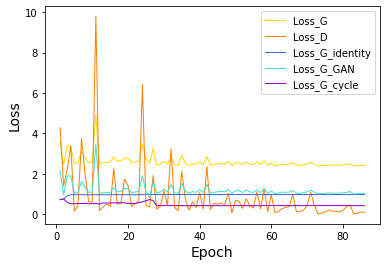

[EPOCH 86/120] [loss_G:2.191326,loss_D:0.025068]:  72%|███████▏  | 56376/77880 [2:22:22<55:26,  6.47it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

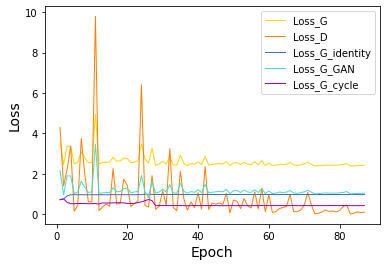

[EPOCH 87/120] [loss_G:2.256660,loss_D:0.002891]:  73%|███████▎  | 57024/77880 [2:23:59<50:43,  6.85it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

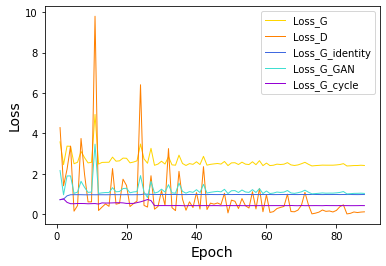

[EPOCH 88/120] [loss_G:2.003073,loss_D:0.150912]:  74%|███████▍  | 57672/77880 [2:25:35<48:44,  6.91it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

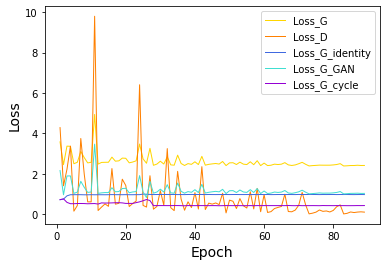

[EPOCH 89/120] [loss_G:2.264382,loss_D:0.098609]:  75%|███████▍  | 58320/77880 [2:27:12<48:45,  6.69it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

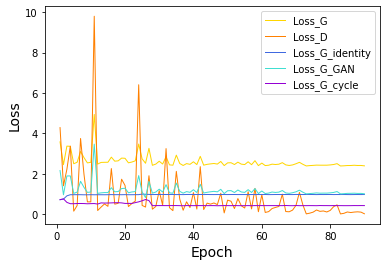

[EPOCH 90/120] [loss_G:2.487761,loss_D:0.002071]:  76%|███████▌  | 58968/77880 [2:28:49<46:11,  6.82it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

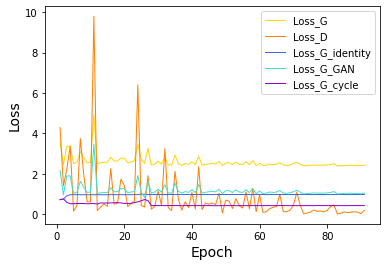

[EPOCH 91/120] [loss_G:2.344301,loss_D:0.000506]:  77%|███████▋  | 59616/77880 [2:30:25<44:40,  6.81it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

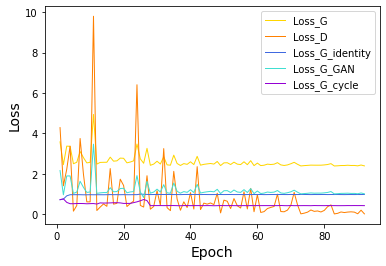

[EPOCH 92/120] [loss_G:2.426970,loss_D:0.001924]:  77%|███████▋  | 60264/77880 [2:32:04<42:31,  6.90it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

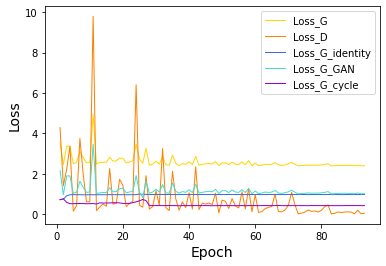

[EPOCH 93/120] [loss_G:2.370421,loss_D:0.000918]:  78%|███████▊  | 60912/77880 [2:33:42<42:04,  6.72it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

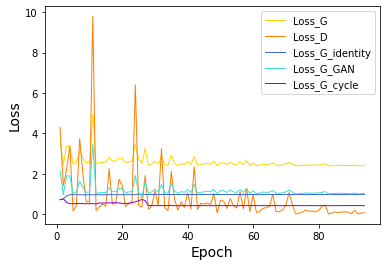

[EPOCH 94/120] [loss_G:2.486529,loss_D:0.003037]:  79%|███████▉  | 61560/77880 [2:35:19<39:59,  6.80it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

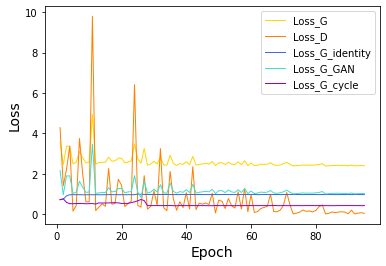

[EPOCH 95/120] [loss_G:2.546882,loss_D:0.034771]:  80%|███████▉  | 62208/77880 [2:36:57<44:33,  5.86it/s]  /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will t

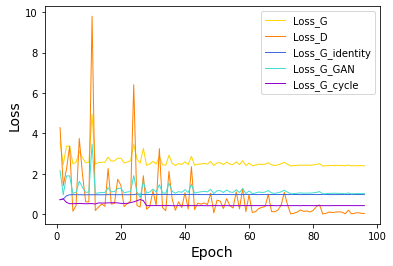

[EPOCH 96/120] [loss_G:2.526907,loss_D:0.014671]:  81%|████████  | 62856/77880 [2:38:33<36:13,  6.91it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will tak

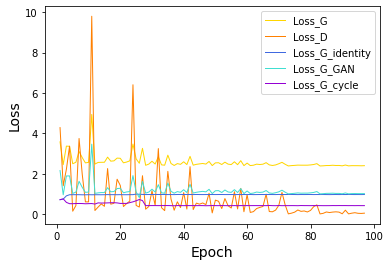

[EPOCH 97/120] [loss_G:2.795694,loss_D:0.000776]:  82%|████████▏ | 63504/77880 [2:40:10<35:34,  6.74it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will tak

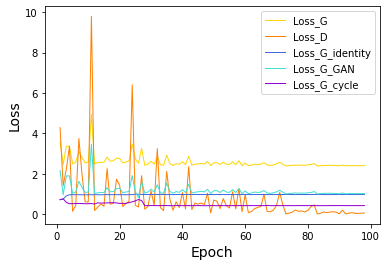

[EPOCH 98/120] [loss_G:2.277512,loss_D:0.000665]:  82%|████████▏ | 64152/77880 [2:41:47<47:20,  4.83it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will tak

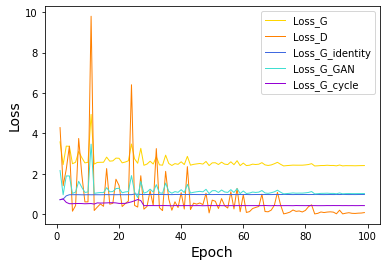

[EPOCH 99/120] [loss_G:2.525495,loss_D:0.008714]:  83%|████████▎ | 64800/77880 [2:43:25<31:31,  6.92it/s] /tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will ta

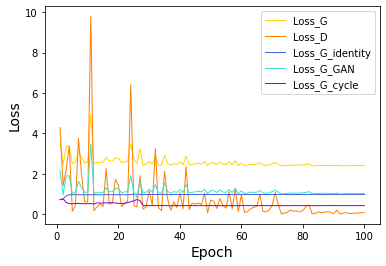

[EPOCH 100/120] [loss_G:2.273933,loss_D:0.000678]:  84%|████████▍ | 65448/77880 [2:45:01<38:14,  5.42it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will ta

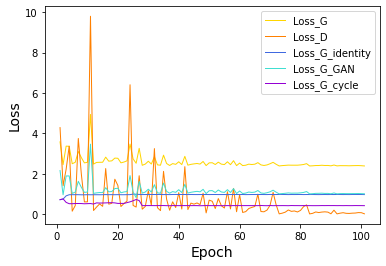

[EPOCH 101/120] [loss_G:2.297323,loss_D:0.002885]:  85%|████████▍ | 66096/77880 [2:46:37<28:25,  6.91it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will ta

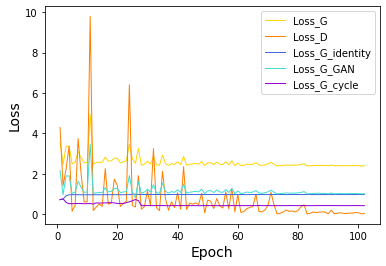

[EPOCH 102/120] [loss_G:2.273631,loss_D:0.023268]:  86%|████████▌ | 66744/77880 [2:48:14<31:08,  5.96it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will ta

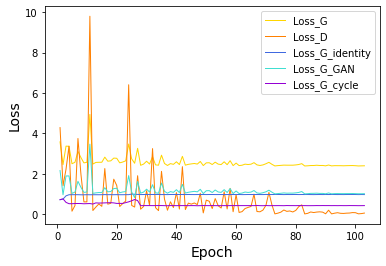

[EPOCH 103/120] [loss_G:2.356647,loss_D:0.000411]:  87%|████████▋ | 67392/77880 [2:49:51<25:27,  6.87it/s]/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will ta

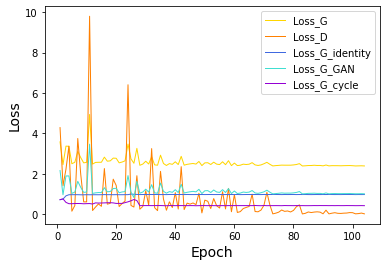

[EPOCH 103/120] [loss_G:2.302502,loss_D:0.000873]:  87%|████████▋ | 67408/77880 [2:49:53<25:18,  6.89it/s]

KeyboardInterrupt: 

In [ ]:
# 训练
for epoch in range(current_epoch, num_epochs):
    lossg=[]
    lossd=[]
    lossgg=[]
    lossid=[]
    lossgc=[]
    for i, batch in enumerate(dataloader):
        # 设置模型输入
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))

        #######固定discriminator，训练generator#######
        Generator_A2B.train()
        Generator_B2A.train()
        optimizer_Generator.zero_grad()

        # Indentity loss
        # 生成器A2B能生成B风格的图像，把B送入G，仍然生成B
        loss_identity_A = criterion_identity(Generator_B2A(real_A), real_A)
        loss_identity_B = criterion_identity(Generator_A2B(real_B), real_B)
        loss_identity = (loss_identity_A + loss_identity_B) / 2

        # GAN loss
        # 使得生成的图片在discriminator中的得分尽可能高
        fake_B = Generator_A2B(real_A)
        loss_GAN_A2B = criterion_GAN(Discriminator_B(fake_B), target_real)
        fake_A = Generator_B2A(real_B)
        loss_GAN_B2A = criterion_GAN(Discriminator_A(fake_A), target_real)
        loss_GAN = (loss_GAN_A2B + loss_GAN_B2A) / 2

        # Cycle consistency loss
        # 使得A通过A2B生成器生成的图片经过B2A生成器之后，与输入的A类似
        loss_cycle_ABA = criterion_cycle(Generator_B2A(fake_B), real_A)
        loss_cycle_BAB = criterion_cycle(Generator_A2B(fake_A), real_B)
        loss_cycle = (loss_cycle_ABA + loss_cycle_BAB) / 2

        # 计算总损失，反向传播，更新参数
        loss_Generator_total = loss_GAN + loss_cycle + loss_identity
        loss_Generator_total.backward()
        optimizer_Generator.step()

        #######固定generator，训练Discriminator_A#######
        Discriminator_A.train()
        optimizer_Discriminator_A.zero_grad()
        # Real loss，使得真实图片的得分尽可能高
        loss_real = criterion_GAN(Discriminator_A(real_A), target_real)
        # Fake loss，使得生成器生成的图片的得分尽可能低
        Fake_A = fake_A_buffer.push_and_pop(fake_A)  # 存储之前generator生成的图片，并且随机返回一张
        loss_fake = criterion_GAN(Discriminator_A(Fake_A.detach()), target_fake)
        loss_Discriminator_A_total = (loss_fake + loss_real) / 2
        # 计算总损失，反向传播，更新参数
        loss_Discriminator_A_total.backward()
        optimizer_Discriminator_A.step()

        #######固定generator，训练Discriminator_B#######
        Discriminator_B.train()
        optimizer_Discriminator_B.zero_grad()
        # Real loss，使得真实图片的得分尽可能高
        loss_real = criterion_GAN(Discriminator_B(real_B), target_real)
        # Fake loss，使得生成器生成的图片的得分尽可能低
        Fake_B = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(Discriminator_B(Fake_B.detach()), target_fake)
        # 计算总损失，反向传播，更新参数
        loss_Discriminator_B_total = (loss_fake + loss_real) / 2
        loss_Discriminator_B_total.backward()
        optimizer_Discriminator_B.step()

        loss_Discriminator_total = (loss_Discriminator_A_total + loss_Discriminator_B_total) / 2
        # 进度条显示
        pbar.set_description("[EPOCH %d/%d] [loss_G:%f,loss_D:%f]" % (
        logger.current_epoch - 1, num_epochs, loss_Generator_total,
        loss_Discriminator_A_total + loss_Discriminator_B_total))
        logger.log()
        pbar.update(1)
        
        # 暂存每个batch的loss
        lossg.append(loss_Generator_total.cpu().item())
        lossd.append((loss_Discriminator_A_total + loss_Discriminator_B_total).cpu().item())
        lossid.append(loss_identity.cpu().item())
        lossgc.append(loss_cycle.cpu().item())
        lossgg.append(loss_GAN.cpu().item())
    
    # 风格迁移结果、损失函数
    logger.save({'loss_G': np.mean(lossg), 'loss_G_identity': np.mean(lossid), 'loss_G_GAN': np.mean(lossgg),
                    'loss_G_cycle': np.mean(lossgc), 'loss_D': np.mean(lossd)})
    # 打印损失曲线
    logger.visualize()
    
    # 更新学习率
    lr_scheduler_Generator.step()
    lr_scheduler_Discriminator_A.step()
    lr_scheduler_Discriminator_B.step()

    # 存储参数
    if epoch == 0 or loss1 > np.mean(lossg):
        loss1 = np.mean(lossg)
        torch.save(Generator_A2B.state_dict(), "saved_models/Generator_A2B")
        torch.save(Generator_B2A.state_dict(), "saved_models/Generator_B2A")
    if epoch == 0 or loss2 > np.mean(lossd):
        loss2 = np.mean(lossd)
        torch.save(Discriminator_A.state_dict(), "saved_models/Discriminator_A")
        torch.save(Discriminator_B.state_dict(), "saved_models/Discriminator_B")
    

# 5. 训练结果绘制及模型的测试
训练全过程的损失函数变化如下图所示，可以发现最后loss已经趋于不变，可以结束迭代。

/tmp/ipykernel_9584/3887878363.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y1, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='Loss_G')
/tmp/ipykernel_9584/3887878363.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y2, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='Loss_D')
/tmp/ipykernel_9584/3887878363.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkviolet" (-> color=(0.5803921568627451, 0.0, 0.8274509803921568, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y3, 'darkviolet',color=(0.25,0.41,0.88), linewidth=1.0, label='Loss_G_identit

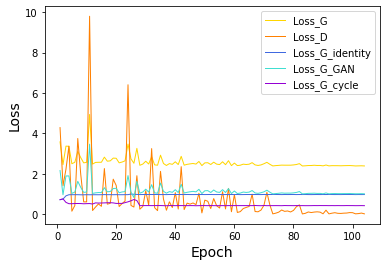

In [ ]:
# 绘制loss图像
logger.visualize()

导入训练完成的参数，进入评估模式。对经过正则化处理的数据进行预测，得到风格迁移的结果。

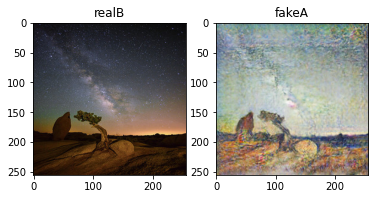

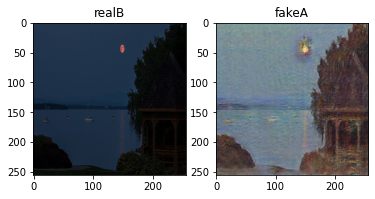

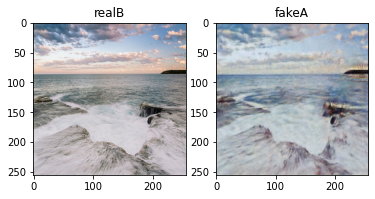

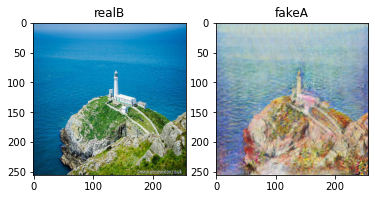

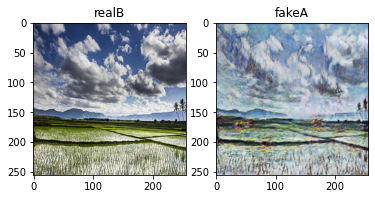

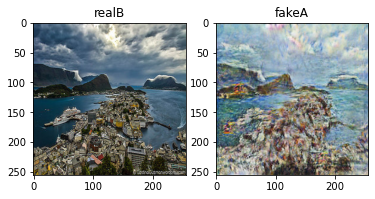

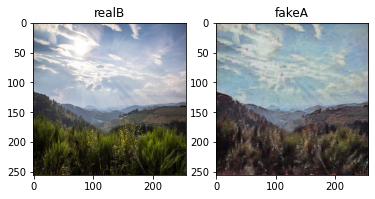

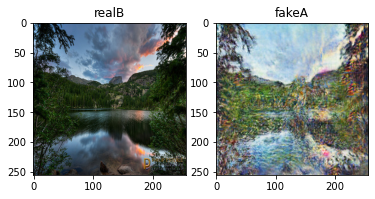

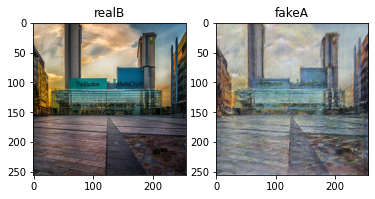

KeyboardInterrupt: 

In [19]:
toPIL = transforms.ToPILImage()
# 参数存储地址
root_Generator_A2B = 'saved_models/Generator_A2B'
root_Generator_B2A = 'saved_models/Generator_B2A'

# 载入参数
Generator_A2B.load_state_dict(torch.load(root_Generator_A2B,map_location=torch.device('cpu')))
Generator_B2A.load_state_dict(torch.load(root_Generator_B2A,map_location=torch.device('cpu')))

# 测试模式
Generator_A2B.eval()
Generator_B2A.eval()
Tensor = torch.Tensor

# 图片预处理
Transform = [transforms.ToTensor(),  # 转为tensor
             transforms.Normalize(0.5, 0.5)
             ]

# 加载测试数据
dataloader = DataLoader(ImageDataset(root, Transform, mode='test'), batch_size, shuffle=False)

for i, batch in enumerate(dataloader):
    # 设置模型输入
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))
    # 生成输出
    fake_B = 1/2 * (Generator_A2B(real_A).data + 1.0)
    fake_A = 1/2 * (Generator_B2A(real_B).data + 1.0)
    # 对部分结果进行可视化
    if i >= 34 and i <= 43 and i != 38:
        plt.figure()
        plt.subplot(1,2,1), plt.title('realB')
        image_real_B = Image.open(sorted(glob.glob(os.path.join(root, '%sB' % 'test') + '/*.*'))[i])
        plt.imshow(image_real_B)
        plt.subplot(1,2,2), plt.title('fakeA')
        plt.imshow(toPIL(fake_A.squeeze())) 
        plt.show()
    # 存储生成的图像
    save_image(fake_A, 'output/A/%04d.png' % (i+1))
    save_image(fake_B, 'output/B/%04d.png' % (i+1))